In [29]:
import numpy as np
import os
os.chdir("C:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH")

In [30]:
import pandas as pd
from src.stk_search import Database_utils
import importlib
importlib.reload(Database_utils)
#%% 
# Load the searched space
df_path = 'data/output/Full_datatset/df_total_new2023_08_20.csv'
df_precursors_path = 'data/output/Prescursor_data/calculation_data_precursor_190923_clean.pkl'#'Data/output/Prescursor_data/calculation_data_precursor_310823_clean.pkl'
df_total, df_precursors = Database_utils.load_data_from_file(df_path, df_precursors_path)


C:\Users\ma11115\OneDrive - Imperial College London\github_folder\STK_SEARCH\src\stk_search\Database_utils.py:106: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


In [2]:
import numpy as np
slatm_rpr = np.load('data/output/Full_dataset/repr_df_total_new2023_08_20.npy',allow_pickle=True)
slatm_name = np.load('data/output/Full_dataset/names_df_total_new2023_08_20.npy',allow_pickle=True)

In [152]:
#np.isnan(slatm_rpr).any()
import pandas as pd
slatm_rpr_new=slatm_rpr
print(slatm_rpr_new.shape)
slatm_rpr_new = slatm_rpr_new[:, ~(slatm_rpr_new == slatm_rpr_new[0,:]).all(0)]
print(slatm_rpr_new.shape)

(40975, 40221)
(40975, 14719)


In [172]:
df_total['fosc1']

0        0.1243
1        0.1121
2        0.0925
3        0.1829
4        0.0999
          ...  
40970    0.4610
40971    0.0377
40972    2.6017
40973    0.0085
40974    0.0987
Name: fosc1, Length: 40975, dtype: float64

In [28]:
from sklearn.decomposition import PCA
PCA_components = 1000
pca = PCA(n_components=PCA_components)
pca.fit(slatm_rpr_new)
pca_rpr = pca.transform(slatm_rpr_new)
pca_rpr.shape

KeyboardInterrupt: 

In [173]:
from stk_search import Search_algorithm
from stk_search import Searched_space
from stk_search import Database_utils
import importlib
importlib.reload(Search_algorithm)

# add pca to df_total

# distribute pca_rpr column to each element
PCA_components=14719
def prepare_search_sapce_data_slatm(SP):
    df_new = pd.concat([df_total, pd.DataFrame(a)], axis=1)
    searched_space_df = SP.check_df_for_element_from_SP(df_to_check=df_new)
    searched_space_df=searched_space_df[searched_space_df['target']>-7]
    searched_space_df_sample = searched_space_df.sample(100)
    fitness_acquired_sample = searched_space_df_sample['target'].values
    fitness_acquired = searched_space_df['fosc1'].values
    searched_space_df=searched_space_df[[x for x in range(PCA_components)]]
    searched_space_df_sample = searched_space_df_sample[[x for x in range(10)]]
    return searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample

In [157]:
from stk_search import Search_algorithm
from stk_search import Searched_space
from stk_search import Database_utils
import importlib
importlib.reload(Search_algorithm)

def prepare_search_sapce_data(SP):
    SP.add_TSNE_to_df_precuros()
    print(len(SP.precursor_TSNE_X_2d))
    #SP.features_frag=SP.features_frag.append(df_precursors.columns[29:38])
    SP.features_frag=SP.features_frag.append(df_precursors.columns[1:7])
    SP.features_frag=SP.features_frag.append(df_precursors.columns[17:23])
    SP.features_frag=SP.features_frag.append(df_precursors.columns[:1])
    print(SP.features_frag)
    searched_space_df = SP.check_df_for_element_from_SP(df_to_check=df_total)
    searched_space_df=searched_space_df[searched_space_df['target']>-10]

    searched_space_df_sample = searched_space_df.sample(100)
    fitness_acquired_sample = searched_space_df_sample['target'].values
    fitness_acquired = searched_space_df['target'].values
    col_list = []
    for x in SP.features_frag:
        for i in range(6):
            col_list.append(x+f'_{i}')
    searched_space_df = searched_space_df[col_list]
    numeric_cols = searched_space_df.select_dtypes(include=['float64', 'int64','float32']).columns
    searched_space_df = searched_space_df[numeric_cols]
    searched_space_df_sample=searched_space_df_sample[col_list]
    searched_space_df_sample = searched_space_df_sample[numeric_cols]
    return searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample

Training size torch.Size([375, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0980], dtype=torch.float64), std = tensor([0.9873], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: -0.01
MSE score: 1.04
MAE score: 0.84
R2 score: 0.99
MSE score: 0.01
MAE score: 0.07


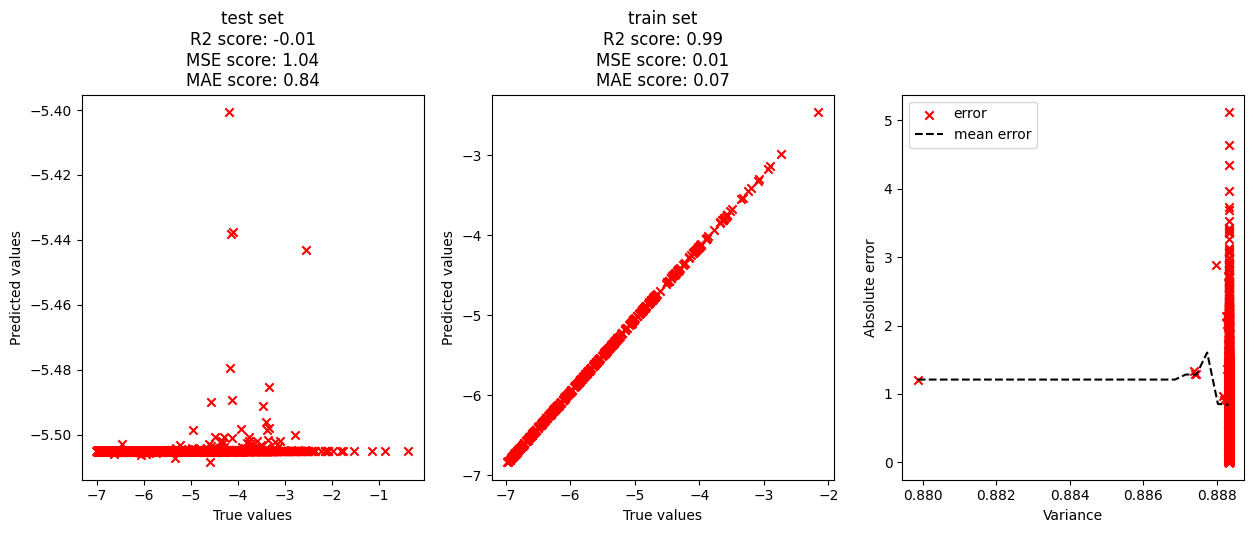

In [155]:
# get the search space using slatm


SP = Searched_space.Searched_Space(number_of_fragments=6,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
# run BO

searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample = prepare_search_sapce_data_slatm(SP)
BO = Search_algorithm.Bayesian_Optimisation()
BO.verbose = True
from botorch.models.gp_regression import SingleTaskGP
BO.kernel = SingleTaskGP
%matplotlib inline
X_train, X_test, y_train , y_test, y_scaler   = BO.get_test_train_data_for_BO(searched_space_df,fitness_acquired,test_set_size=0.9)  
print('Training size',X_train.shape)
y_pred, y_var, y_pred_train, y_train, y_test, y_var_train = BO.test_model_prediction(X_train, y_train, X_test, y_test, y_scaler)
BO.plot_prediction(y_pred,y_test,y_pred_train,y_train,y_var)


Training size torch.Size([37, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1917], dtype=torch.float64), std = tensor([1.1180], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: -0.04
MSE score: 0.90
MAE score: 0.78
R2 score: 0.00
MSE score: 1.05
MAE score: 0.81


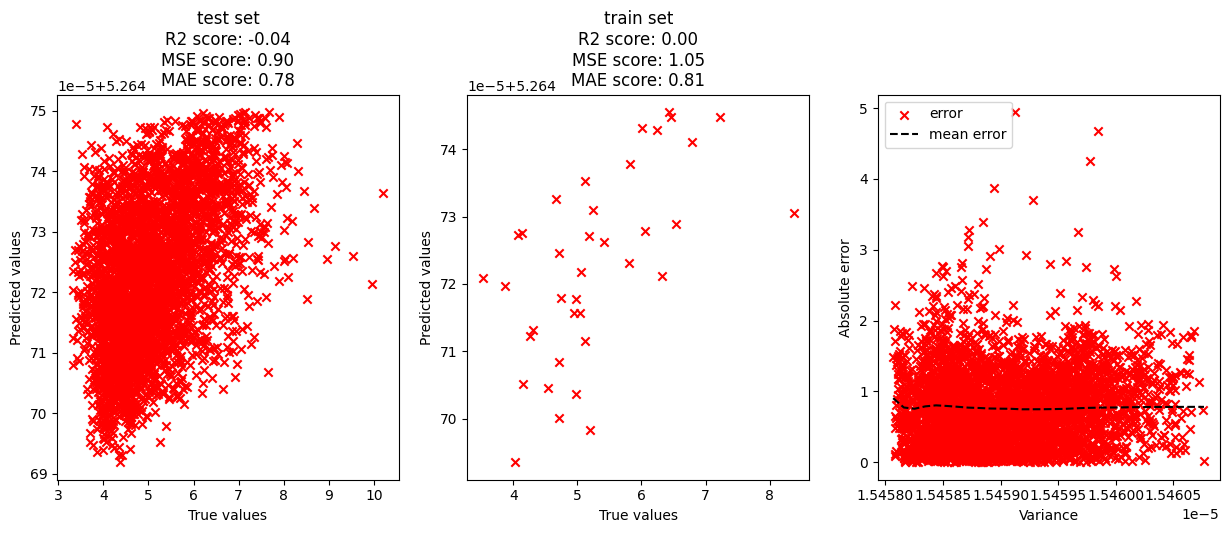

Training size torch.Size([112, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0226], dtype=torch.float64), std = tensor([0.9796], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.30
MSE score: 0.61
MAE score: 0.60
R2 score: 0.57
MSE score: 0.35
MAE score: 0.45


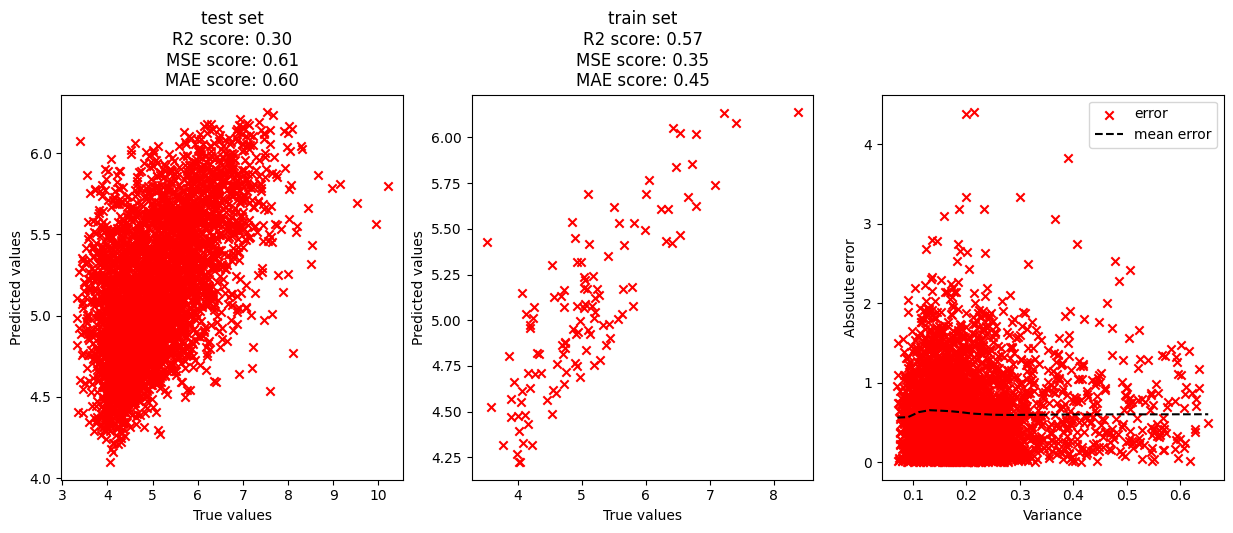

Training size torch.Size([187, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0501], dtype=torch.float64), std = tensor([0.9810], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.37
MSE score: 0.55
MAE score: 0.57
R2 score: 0.65
MSE score: 0.29
MAE score: 0.41


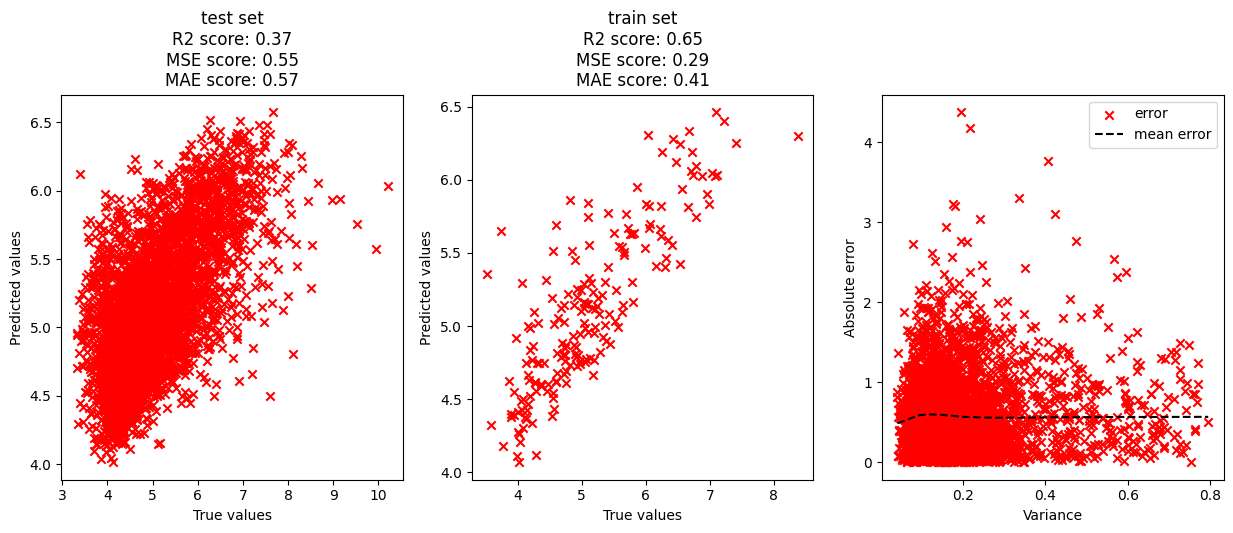

Training size torch.Size([375, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1188], dtype=torch.float64), std = tensor([0.9644], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.49
MSE score: 0.45
MAE score: 0.50
R2 score: 0.74
MSE score: 0.21
MAE score: 0.34


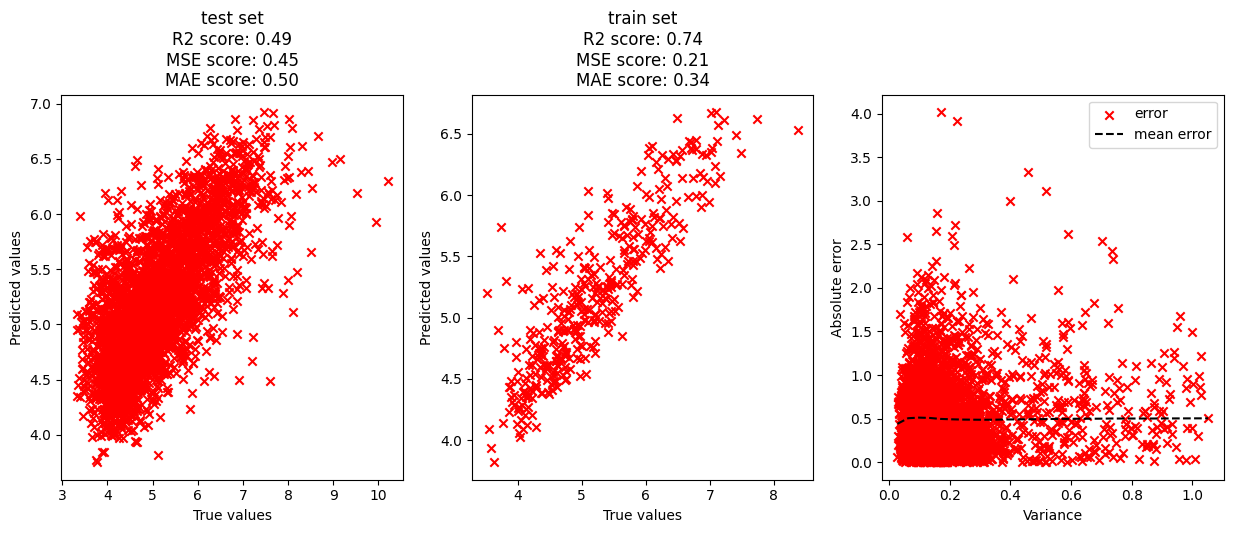

Training size torch.Size([750, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0418], dtype=torch.float64), std = tensor([0.9457], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.56
MSE score: 0.39
MAE score: 0.46
R2 score: 0.76
MSE score: 0.18
MAE score: 0.31


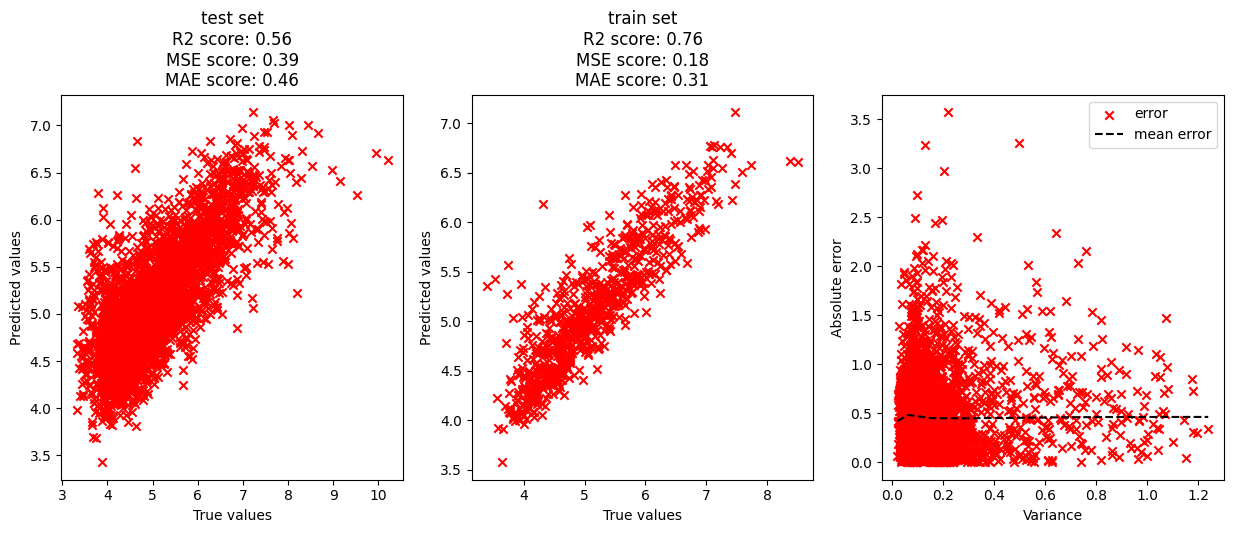

In [175]:
from botorch.models.gp_regression import SingleTaskGP
from stk_search.tanimoto_kernel import TanimotoKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch import kernels 
import importlib
importlib.reload(Search_algorithm)
class test_kernel(SingleTaskGP):
    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y, GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(base_kernel=TanimotoKernel())#kernels.RBFKernel())#)
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample = prepare_search_sapce_data_slatm(SP)
BO = Search_algorithm.Bayesian_Optimisation()
BO.verbose = True
BO.kernel = test_kernel
%matplotlib inline
test_set_size=0.9
for test_set_size in [0.99,0.97,0.95,0.9,0.8]:
    X_train, X_test, y_train , y_test, y_scaler   = BO.get_test_train_data_for_BO(searched_space_df,fitness_acquired,test_set_size=test_set_size)  
    print('Training size',X_train.shape)
    y_pred, y_var, y_pred_train, y_train, y_test, y_var_train = BO.test_model_prediction(X_train, y_train, X_test, y_test, y_scaler)
    fig_name='Fosc1_trainsize_'+str(X_train.shape[0])+'_testSi_'+str(X_test.shape[0])+'_kernel_'+'tanimoto'+'.png'
    BO.plot_prediction(y_pred,y_test,y_pred_train,y_train,y_var,save_plot=True,plot_name=fig_name)


R2 score: 0.42
MSE score: 0.59
MAE score: 0.60
R2 score: 0.83
MSE score: 0.16
MAE score: 0.31


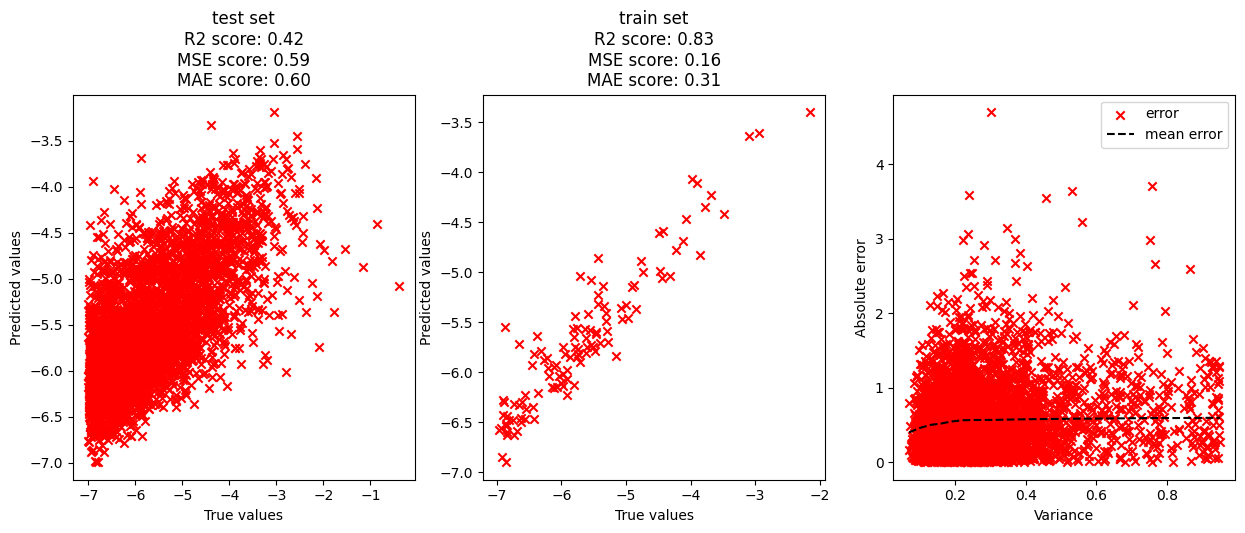

In [165]:
BO.plot_prediction(y_pred,y_test,y_pred_train,y_train,y_var,save_plot=True,plot_name=fig_name)


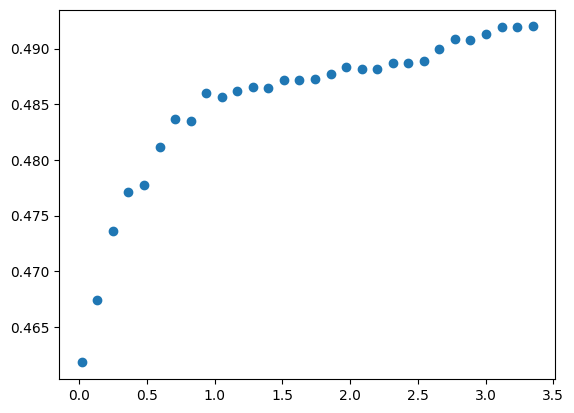

In [135]:
tes = [y_var>x] and [y_var<y]
y_pred[tes[0]].mean()

-5.519071889174277

312
Index(['InChIKey', 'Atom_num', 'HOMO (eV)', 'LUMO (eV)', 'HOMO_LUMO_GAP (eV)',
       'IP (eV)', 'EA (eV)', '1 Excited state Energy (eV)',
       '1 Excited state Osc', '2 Excited state Energy (eV)',
       '2 Excited state Osc', '3 Excited state Energy (eV)',
       '3 Excited state Osc', 'InChIKey'],
      dtype='object')
Training size torch.Size([1592, 72])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0118], dtype=torch.float64), std = tensor([1.0061], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.52
MSE score: 1.27
MAE score: 0.83
R2 score: 0.76
MSE score: 0.64
MAE score: 0.59


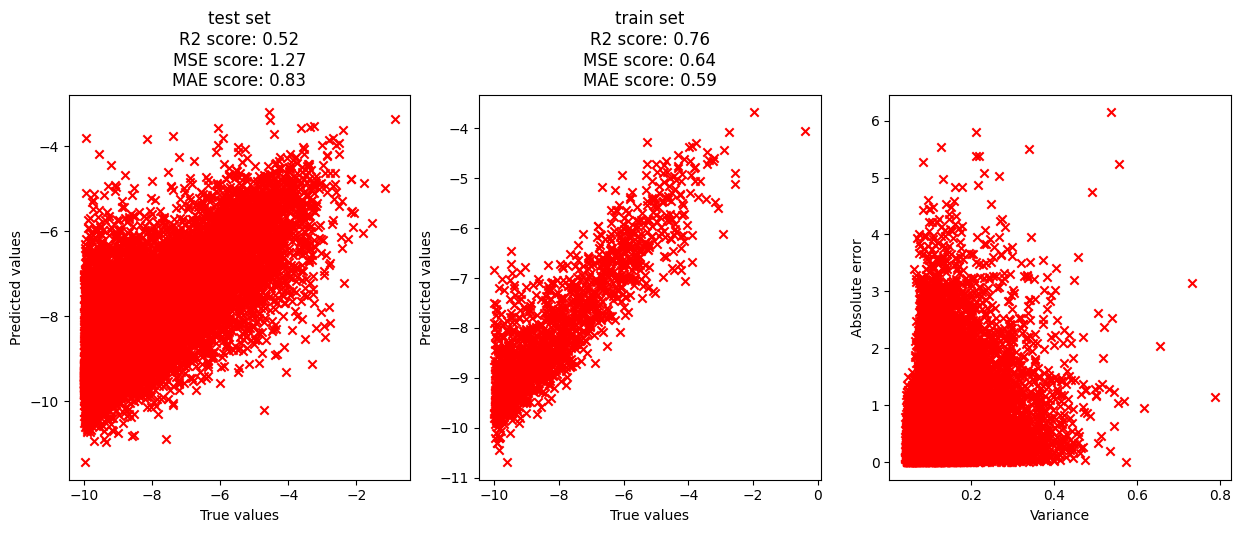

In [61]:
SP = Searched_space.Searched_Space(number_of_fragments=6,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
# run BO

searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample = prepare_search_sapce_data(SP)
BO = Search_algorithm.Bayesian_Optimisation()
BO.verbose = True
%matplotlib inline
X_train, X_test, y_train , y_test, y_scaler   = BO.get_test_train_data_for_BO(searched_space_df,fitness_acquired,test_set_size=0.9)  
print('Training size',X_train.shape)
y_pred, y_var, y_pred_train, y_train, y_test, y_var_train = BO.test_model_prediction(X_train, y_train, X_test, y_test, y_scaler)
BO.plot_prediction(y_pred,y_test,y_pred_train,y_train,y_var)

Training size torch.Size([218, 1000])
R2 score: 0.66
MSE score: 0.04
MAE score: 0.14
R2 score: 1.00
MSE score: 0.00
MAE score: 0.01


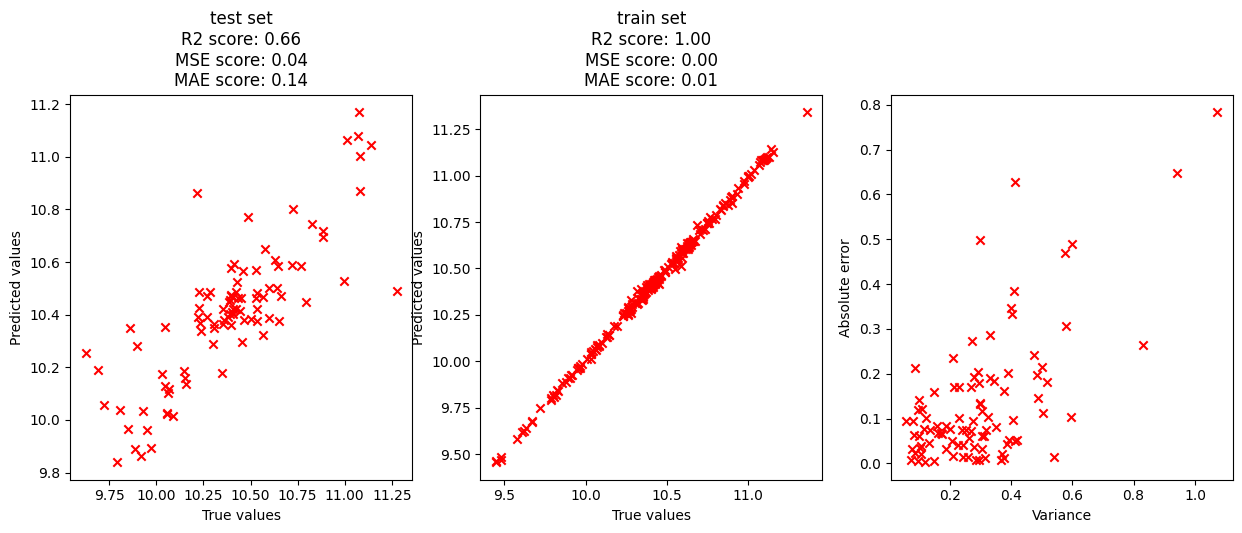

In [282]:
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.model_selection import train_test_split

PCA_components = 3
pca = PCA(n_components=PCA_components)
pca.fit(slatm_rpr)
pca_rpr = pca.transform(slatm_rpr)
def get_test_train_data_for_BO(
        search_space_df: pd.DataFrame = [],
        fitness_acquired: list = [],
        test_set_size: float = 0.2,
    ):
        def transform_data(X_train, y_train, X_test, y_test):
            """
            Apply feature scaling, dimensionality reduction to the data. Return the standardised and low-dimensional train and
            test sets together with the scaler object for the target values.

            :param X_train: input train data
            :param y_train: train labels
            :param X_test: input test data
            :param y_test: test labels
            :return: X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_scaler
            """
            X_train_scaled = (X_train - X_train.min(axis=0).values) / (
                X_train.max(axis=0).values - X_train.min(axis=0).values+0.01
            )
            X_test_scaled = (X_test - X_test.min(axis=0).values) / (
                X_test.max(axis=0).values - X_test.min(axis=0).values+0.01
            )
            y_scaler = StandardScaler()
            y_train_scaled = y_scaler.fit_transform(y_train)
            y_test_scaled = y_scaler.transform(y_test)

            return (
                X_train_scaled,
                y_train_scaled,
                X_test_scaled,
                y_test_scaled,
                y_scaler,
            )

        X_explored = torch.tensor(
            search_space_df.values, dtype=torch.float64
        )
        # limit the dataframe to only the numeric data
        y_explored = torch.tensor(
            fitness_acquired, dtype=torch.float64
        )

        X_train, X_test, y_train, y_test = train_test_split(
            X_explored, y_explored, test_size=test_set_size, random_state=0
        )

        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        #  We standardise the outputs but leave the inputs unchanged

        X_train, y_train, X_test, y_test, y_scaler = transform_data(
            X_train, y_train, X_test, y_test
        )
        return X_train, X_test, y_train, y_test, y_scaler
for x in range(PCA_components):
    df_precursors['pca'+str(x)] = pca_rpr[:,x]
BO = Search_algorithm.Bayesian_Optimisation()
BO.verbose = True
searched_space_df= df_slatm[['slatm_rpr'+str(x) for x in range(1000)]]
#numeric_cols = searched_space_df.select_dtypes(include=['float64', 'int64','float32']).columns
#searched_space_df = searched_space_df[numeric_cols]
df_slatm['target'] = np.abs(df_slatm['1 Excited state Energy (eV)']-4)+np.abs(df_slatm['1 Excited state Osc']-10)
fitness_acquired=df_slatm['target'].values
X_train, X_test, y_train , y_test, y_scaler   = get_test_train_data_for_BO(searched_space_df,fitness_acquired,test_set_size=0.3)  
print('Training size',X_train.shape)
%matplotlib inline

y_pred, y_var, y_pred_train, y_train, y_test, y_var_train = BO.test_model_prediction(X_train, y_train, X_test, y_test, y_scaler)
BO.plot_prediction(y_pred,y_test,y_pred_train,y_train,y_var)


In [110]:
numeric_cols = searched_space_df.select_dtypes(include=['float64', 'int64','float32']).columns
searched_space_df = searched_space_df[numeric_cols]

In [261]:
searched_space_df= df_slatm[['slatm_rpr'+str(x) for x in range(1000)]]

numeric_cols = searched_space_df.select_dtypes(include=['float64', 'int64','float32',]).columns
numeric_cols

Index([], dtype='object')

In [275]:
df_slatm

InChIKey  slatm_rpr0  slatm_rpr1  slatm_rpr2  \
0    HNRHIGPDSSXEJA-FARCUNLSSA-N         0.0         2.0        70.0   
1    XMPYSHMKPRWIPF-UQCOIBPSSA-N         0.0         4.0        70.0   
2    NGTUECGTXMWUQR-UHFFFAOYSA-N         0.0         6.0        70.0   
3    LPTRCOXHGVILNO-UHFFFAOYSA-N         0.0        10.0        70.0   
4    ULRLMMWHCRPTDR-UHFFFAOYSA-N        32.0        12.0        70.0   
..                           ...         ...         ...         ...   
307  DGNQPUBGEVNPSD-WMZJFQQLSA-N         0.0         6.0        70.0   
308  NDEGJNYUKUSEKE-UHFFFAOYSA-N         0.0         6.0        70.0   
309  GOHMZODPOMNOAD-UHFFFAOYSA-N         0.0         6.0        70.0   
310  BJFIUKSBVAJFOJ-WTKPLQERSA-N         0.0         4.0        70.0   
311  PQZAHLJJGPAGBD-OQFOIZHKSA-N         0.0         3.0        70.0   

     slatm_rpr3  slatm_rpr4  slatm_rpr5  slatm_rpr6  slatm_rpr7  slatm_rpr8  \
0          78.0        14.0         8.0        18.0         0.0         0.0   
1          72.0        14.0         8.0         0.0        16.0         0.0   
2         102.0        14.0         8.0         0.0         0.0         0.0   
3          72.0         0.0         0.0         0.0        16.0         0.0   
4          72.0         0.0         0.0         0.0        32.0         0.0   
..          ...         ...         ...         ...         ...         ...   
307        84.0        14.0        16.0         0.0         0.0         0.0   
308        78.0         0.0         8.0         0.0         0.0         0.0   
309        78.0         0.0        16.0         0.0        48.0         0.0   
310        78.0        14.0         8.0         0.0         0.0         0.0   
311        78.0        14.0         8.0         9.0         0.0         0.0   

     ...    pca291    pca292    pca293    pca294        pca295        pca296  \
0    ... -0.000486 -0.001931 -0.000326 -0.001384  7.069663e-04  1.773507e-03   
1    ... -0.000523 -0.000253  0.001012 -0.000301  9.990483e-04  4.074271e-04   
2    ...  0.000001  0.000001 -0.000001 -0.000006 -6.165659e-07  3.598747e-07   
3    ... -0.002748 -0.003003 -0.004311 -0.002269  9.413809e-04  5.046281e-03   
4    ...  0.003341  0.002856  0.000870  0.000388  6.310424e-04  1.892832e-03   
..   ...       ...       ...       ...       ...           ...           ...   
307  ... -0.001397  0.000176 -0.000293 -0.000884  4.379985e-04 -8.527248e-04   
308  ...  0.005473  0.008349  0.009332 -0.011940 -6.563415e-03  4.390469e-03   
309  ...  0.003896  0.001554 -0.000069  0.000046 -9.971129e-04 -6.041081e-04   
310  ... -0.001842 -0.000803 -0.001734  0.001580 -3.990065e-03  2.540008e-03   
311  ...  0.000117 -0.000001  0.000014 -0.000040  1.361768e-05  3.026289e-06   

           pca297    pca298    pca299  slatm_rpr  
0   -1.872595e-03  0.000736 -0.000646          0  
1   -6.420646e-05 -0.000253  0.000718          0  
2    1.621629e-07 -0.000001 -0.000001          0  
3    5.373665e-03 -0.001231  0.001335          0  
4    7.182336e-05 -0.001610  0.002070          0  
..            ...       ...       ...        ...  
307  6.904078e-04 -0.001188  0.001192          0  
308 -7.121810e-03 -0.000728  0.003484          0  
309  1.217317e-03 -0.000383  0.001530          0  
310 -1.349843e-03  0.001236  0.002771          0  
311  1.522456e-06 -0.000026  0.000028          0  

[312 rows x 11427 columns]

In [272]:
X_train

tensor([[0.0000, 0.4545,    nan, 0.3333, 0.0000, 0.6667, 0.0000, 0.6667,    nan,
            nan],
        [0.0000, 0.6364,    nan, 0.4167, 0.6667, 0.3333, 0.0000, 0.0000,    nan,
            nan],
        [0.0000, 0.0909,    nan, 0.3333, 0.0000, 0.6667, 0.0000, 0.6667,    nan,
            nan],
        [0.0000, 0.4545,    nan, 1.0000, 0.6667, 0.3333, 0.0000, 0.0000,    nan,
            nan],
        [0.0000, 0.7273,    nan, 0.7500, 0.3333, 0.6667, 0.0000, 0.0000,    nan,
            nan],
        [0.0000, 0.6364,    nan, 0.4167, 0.0000, 0.0000, 0.0000, 0.6667,    nan,
            nan],
        [0.0000, 0.6364,    nan, 0.8333, 0.0000, 0.3333, 0.0000, 1.0000,    nan,
            nan],
        [1.0000, 1.0000,    nan, 0.5833, 0.0000, 0.0000, 0.0000, 0.6667,    nan,
            nan],
        [0.0000, 0.5455,    nan, 0.6667, 0.0000, 0.6667, 0.0000, 1.0000,    nan,
            nan],
        [0.0000, 0.2727,    nan, 0.8333, 0.6667, 0.3333, 0.0000, 0.3333,    nan,
            nan],
        [0

In [214]:
print(slatm_names[0])
print(df_precursors[df_precursors['InChIKey']==slatm_names[0].split('/')[1].replace('.xyz','')]['InChIKey'])
slatm_rpr[0]
for count, name in enumerate(slatm_names):
   InChIKey_slatm = name.split('/')[1].replace('.xyz','')
   df_precursors[df_precursors['InChIKey']==InChIKey_slatm]['slatm_rpr'] =  [slatm_rpr[count]]

cache/HNRHIGPDSSXEJA-FARCUNLSSA-N.xyz
254    HNRHIGPDSSXEJA-FARCUNLSSA-N
Name: InChIKey, dtype: object


C:\Users\ma11115\AppData\Local\Temp\ipykernel_1512\3848055705.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_precursors[df_precursors['InChIKey']==InChIKey_slatm]['slatm_rpr'] =  [slatm_rpr[count]]


In [233]:
import pandas as pd
df_slatm = pd.DataFrame(slatm_names,columns=['InChIKey'])
#df_slatm['slatm_rpr']=slatm_rpr

In [247]:
for x in range(slatm_rpr.shape[1]):
    df_slatm['slatm_rpr'+str(x)]= slatm_rpr[:,x]

C:\Users\ma11115\AppData\Local\Temp\ipykernel_1512\198950341.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_slatm['slatm_rpr'+str(x)]= slatm_rpr[:,x]
C:\Users\ma11115\AppData\Local\Temp\ipykernel_1512\198950341.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_slatm['slatm_rpr'+str(x)]= slatm_rpr[:,x]
C:\Users\ma11115\AppData\Local\Temp\ipykernel_1512\198950341.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

In [250]:
df_slatm['InChIKey']=df_slatm['InChIKey'].apply(lambda x: x.split('/')[1].replace('.xyz',''))

IndexError: list index out of range

In [269]:
df_slatm.

0